In [205]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn import linear_model, decomposition, datasets
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
%matplotlib inline

In [206]:
#Goal is to create a model that's able to predict breast cancer.
df = pd.read_csv('cancer.csv')

In [207]:
#Drop Sample Code
df = df.drop('Sample_Code', axis=1)

In [208]:
#Convert Malignant Class to 1 and benign to 0
df['Class_Cat'] = np.where(df['Class']==4, 1, 0)

In [209]:
df['Bare_Nuclei'] = df['Bare_Nuclei'].replace('?', 0)

In [210]:
df['Bare_Nuclei'] = pd.to_numeric(df['Bare_Nuclei'])

In [211]:
df['Bare_Nuclei'].fillna((df['Bare_Nuclei'].mean()), inplace=True)

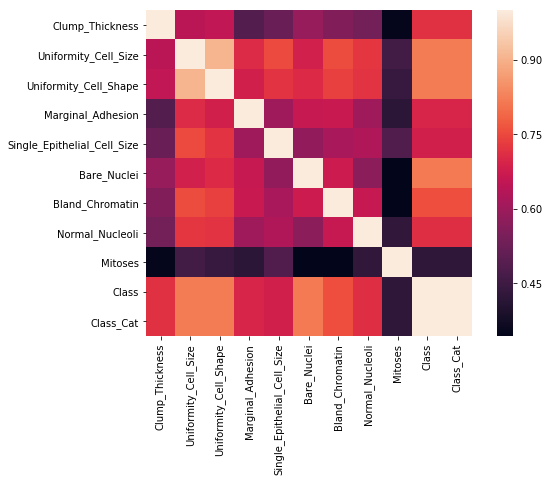

In [212]:
#Creating a correlation matrix.
corrmat = df.corr()
#Find correlation between the different variables.
f, ax = plt.subplots(figsize=(9,6))
sns.heatmap(corrmat, square=True)
#Cell Size and Cell Shape are highly correlated.

In [213]:
#Logistic Regression
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

lr = LogisticRegression(C=1e9)
y = df['Class_Cat']
X = df[['Clump_Thickness','Uniformity_Cell_Size','Marginal_Adhesion', 'Single_Epithelial_Cell_Size',
        'Normal_Nucleoli','Mitoses','Bland_Chromatin','Bare_Nuclei']]

# Declare predictors.
X_statsmod = df[['Clump_Thickness','Uniformity_Cell_Size','Marginal_Adhesion', 'Single_Epithelial_Cell_Size',
        'Normal_Nucleoli','Mitoses','Bland_Chromatin','Bare_Nuclei']]

# The Statsmodels formulation requires a column with constant value 1 that
# will act as the intercept.
X_statsmod['intercept'] = 1 

# Declare and fit the model.
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.384728
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              Class_Cat   No. Observations:                  699
Model:                          Logit   Df Residuals:                      691
Method:                           MLE   Df Model:                            7
Date:                Thu, 28 Dec 2017   Pseudo R-squ.:                  0.4027
Time:                        23:24:10   Log-Likelihood:                -268.92
converged:                       True   LL-Null:                       -450.26
                                        LLR p-value:                 2.378e-74
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Clump_Thickness                -0.3182      0.055     -5.771      0.000   

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.96


In [215]:
#Cross Validation
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.962


In [216]:
#Define the training and test sizes
trainsize = int(df.shape[0]*0.8)  
df_test = df.iloc[trainsize:, :].copy() 
df_train = df.iloc[:trainsize, :].copy()

#Set up regression model to predict defaults using all other variables as features
regr1 = linear_model.LinearRegression()
Y_train = df_train['Class_Cat'].values.reshape(-1, 1)
X_train = df_train[['Clump_Thickness','Uniformity_Cell_Size','Marginal_Adhesion', 'Single_Epithelial_Cell_Size',
        'Normal_Nucleoli','Mitoses','Bland_Chromatin','Bare_Nuclei']]
regr1.fit(X_train, Y_train)
print('\nR-squared simple model:')
print(regr1.score(X_train, Y_train))

#Store the parameter estimates.
origparams = np.append(regr1.coef_, regr1.intercept_) 

# Make new features to capture relationships between the features.

df_train['Thickness_Cell_Size'] = df_train['Clump_Thickness'] * df_train['Uniformity_Cell_Size'] 
df_train['Adhesion_Mitoses'] = df_train['Marginal_Adhesion'] * df_train['Mitoses']
df_train['Nucleoli_Mitoses'] = df_train['Normal_Nucleoli'] * df_train['Mitoses']
df_train['Thickness_Epithelial_Size'] = df_train['Clump_Thickness'] * df_train['Single_Epithelial_Cell_Size']
df_train['Adhesion_Nucleoli'] = df_train['Marginal_Adhesion'] * df_train['Normal_Nucleoli']

                             
# Re-run the model with the new features.
regrBig = linear_model.LinearRegression()
X_train2 = df_train[['Clump_Thickness','Uniformity_Cell_Size','Marginal_Adhesion', 'Single_Epithelial_Cell_Size',
        'Normal_Nucleoli','Mitoses','Thickness_Cell_Size','Adhesion_Mitoses','Nucleoli_Mitoses',
                    'Thickness_Epithelial_Size','Adhesion_Nucleoli']]
regrBig.fit(X_train2, Y_train)
print('\nR-squared complex model:')
print(regrBig.score(X_train2, Y_train))

# Store the new parameter estimates for the same features.
newparams = np.append(
    regrBig.coef_[0,0:(len(origparams)-1)],
    regrBig.intercept_)

print('\nParameter Estimates for the same predictors for the small model '
      'and large model:')
compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)


R-squared simple model:
0.824199970916

R-squared complex model:
0.782291139352

Parameter Estimates for the same predictors for the small model and large model:
[[0.039 0.068]
 [0.025 0.072]
 [0.006 0.060]
 [0.009 0.033]
 [0.020 0.054]
 [0.006 0.057]
 [0.016 -0.004]
 [0.050 -0.004]
 [-0.249 -0.445]]


In [217]:
# Test the simpler model with smaller coefficients.
Y_test = df_test['Class_Cat'].values.reshape(-1, 1)
X_test = df_test[['Clump_Thickness','Uniformity_Cell_Size','Marginal_Adhesion', 'Single_Epithelial_Cell_Size',
        'Normal_Nucleoli','Mitoses','Bland_Chromatin','Bare_Nuclei']]
print('\nR-squared simple model:')
print(regr1.score(X_test, Y_test))

# Test the more complex model with larger coefficients.
df_test['Thickness_Cell_Size'] = df_test['Clump_Thickness'] * df_test['Uniformity_Cell_Size'] 
df_test['Adhesion_Mitoses'] = df_test['Marginal_Adhesion'] * df_test['Mitoses']
df_test['Nucleoli_Mitoses'] = df_test['Normal_Nucleoli'] * df_test['Mitoses']
df_test['Thickness_Epithelial_Size'] = df_test['Clump_Thickness'] * df_test['Single_Epithelial_Cell_Size']
df_test['Adhesion_Nucleoli'] = df_test['Marginal_Adhesion'] * df_test['Normal_Nucleoli']


# Re-run the model with the new features.
X_test2 = df_test[['Clump_Thickness','Uniformity_Cell_Size','Marginal_Adhesion', 'Single_Epithelial_Cell_Size',
        'Normal_Nucleoli','Mitoses','Thickness_Cell_Size','Adhesion_Mitoses','Nucleoli_Mitoses',
                    'Thickness_Epithelial_Size','Adhesion_Nucleoli']]
print('\nR-squared complex model:')
print(regrBig.score(X_test2, Y_test))


R-squared simple model:
0.88014671755

R-squared complex model:
0.875712792606


In [218]:
#Testing using KNN Model

In [219]:
# Run the same model, this time with weights.
from sklearn import neighbors
knn_w = neighbors.KNeighborsRegressor(n_neighbors=50, weights='distance')
Y = df['Class_Cat'].values.reshape(-1,1)
X = df[['Clump_Thickness','Uniformity_Cell_Size','Marginal_Adhesion', 'Single_Epithelial_Cell_Size',
        'Normal_Nucleoli','Mitoses','Bland_Chromatin','Bare_Nuclei']]

In [220]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(559, 8) (559, 1)
(140, 8) (140, 1)


In [221]:
knn.fit(X_train, Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='uniform')

In [222]:
from sklearn.model_selection import cross_val_score
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
score = cross_val_score(knn, X, Y, cv=10)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: 0.88 (+/- 0.23)
Weighted Accuracy: 0.85 (+/- 0.24)


In [223]:
#Testing using Naive Bayes

In [224]:
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [225]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
    
#Testing my Naive Bayes Classifier
BNB = BernoulliNB()
BNB.fit(X_train, y_train)
    
y_pred = BNB.predict(X_test)
    
NB_sk = GaussianNB()
NB_sk.fit(X_train, y_train)
    
sk_pred = NB_sk.predict(X_test)
     
print('Accuracy of Bernoulli classifier on test set: {:.2f}'.format(BNB.score(X_test, y_test)))
print('Accuracy of Gaussaian classifier on test set: {:.2f}'.format(NB_sk.score(X_test, y_test)))

Accuracy of Bernoulli classifier on test set: 0.97
Accuracy of Gaussaian classifier on test set: 0.96
